In [39]:
import os
import pickle
import numpy as np
import pandas as pd
import torch
import utils
from utils import *
from importlib import reload
reload(utils)
from sklearn.metrics import (precision_score, recall_score, f1_score,
                             roc_auc_score, accuracy_score, confusion_matrix)

from sklearn.model_selection import train_test_split

# Model Testing and Plot ROC Curve

Running on : cuda


Model: TorchX-SBU-RSNA_SGD_.00005_bs64
after processing -1024.0 1024.0
Testing data distribution
x_test torch.Size([180, 1, 512, 512])
# of True:  54
# of False:  126
------------------------------------------------------------------------------
Test Loss: 0.5935362577438354, Accuracy: 0.7444444444444445
Recall: 0.6296296296296297, Specificity: 0.7936507936507936
Aacc: 71.16402116402116, AUC: 0.7605820105820107
------------------------------------------------------------------------------
Test Loss: 0.5880529284477234, Accuracy: 0.7055555555555556
Recall: 0.5740740740740741, Specificity: 0.7619047619047619
Aacc: 66.7989417989418, AUC: 0.7514697236919459
------------------------------------------------------------------------------
Test Loss: 0.612639844417572, Accuracy: 0.7166666666666667
Recall: 0.7222222222222222, Specificity: 0.7142857142857143
Aacc: 71.82539682539682, AUC: 0.7585243974132863
-----------------------------------------------------------------------

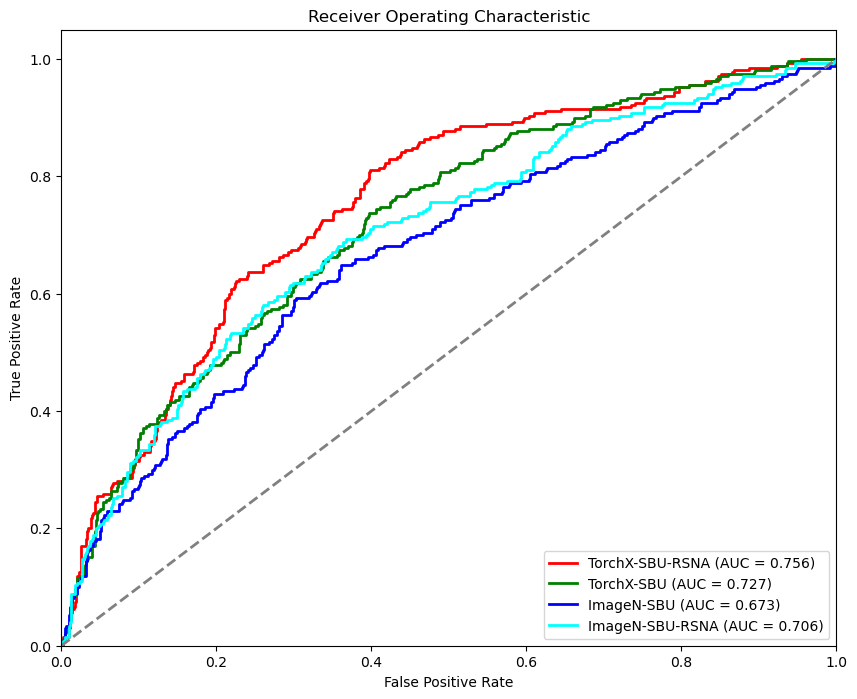

In [37]:
modelNames = [
'TorchX-SBU-RSNA_SGD_.00005_bs64',
'TorchX-SBU_SGD_.00003_bs32',
'ImageN-SBU_Adam_.00001_bs16',
'ImageN-SBU-RSNA_Adam_.00005_bs32'
]

# Colors for the plot
colors = ['red', 'green', 'blue', 'cyan']
legends = ['TorchX-SBU-RSNA', 'TorchX-SBU', 'ImageN-SBU', 'ImageN-SBU-RSNA']
color_index = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on :", device)

plt.figure(figsize=(10, 8))
for modelName in modelNames:
    pretrained = modelName.split('-')[0]
    print(f'\n\nModel: {modelName}')   

    histf = './history/'
    histpath = os.path.join(histf, modelName)
    
    # load testing data
    test_data = np.load('/path/to/test_data.npy')
    test_label = pd.read_csv('/path/to/test_label.csv')
    x_test = np.array(test_data)
    y_test = np.array(test_label['Label'].astype(int))

    # preprocessing according to pretrained model
    x_test, y_test = preprocess_seg(x_test, y_test, 'False', 'False', 0, 0, pretrained)
    x_test = np.transpose(x_test, (0, 3, 1, 2))
    x_test = torch.from_numpy(x_test)
    print('Testing data distribution')
    print('x_test', x_test.shape)
    print('# of True: ', y_test.sum())
    print('# of False: ',len(y_test) - y_test.sum())

    fold_no = 1
    num_folds = 5
    bs = modelName.split('bs')[1]
    all_y_pred = []
    all_y_true = []
    all_AUCs = []
    for i in range(num_folds):
        criterion = torch.nn.BCELoss()
        # Evaluate model on test data
        weightPath = f"{histpath}/checkpoint/model_fold_{fold_no}_best.pt"
        model = load_model_weight(weightPath, pretrained)
        model = model.to(device)
        test_loader = create_data_loader(x_test, y_test, batch_size=int(bs))
        test_loss = 0.0
        test_corrects = 0
        y_pred_list = []  # List to store all predictions
        y_true_list = []  # List to store all true labels
        model.eval()
        for x_test_batch, y_test_batch in test_loader:
            x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
            with torch.no_grad():
                test_outputs = model(x_test_batch).squeeze()
                # fix the mismatch dimension
                if test_outputs.ndim != y_test_batch.ndim:
                    print("test_outputs shape:", test_outputs.shape)
                    print("y_test_batch shape:", y_test_batch.shape)
                    print("Dimension mismatch detected. Adjusting dimensions.")
                    test_outputs = test_outputs.unsqueeze(-1) if test_outputs.ndim < y_test_batch.ndim else test_outputs
                    y_test_batch = y_test_batch.unsqueeze(-1) if y_test_batch.ndim < test_outputs.ndim else y_test_batch
                test_outputs = torch.sigmoid(test_outputs)
                t_loss = criterion(test_outputs, y_test_batch)
                test_loss += t_loss.item()
                test_corrects += (test_outputs.round() == y_test_batch).sum().item()
                y_pred_list.extend(test_outputs.cpu().detach().numpy())  # Convert predictions to probabilities
                y_true_list.extend(y_test_batch.cpu().numpy())

        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = test_corrects / len(y_test)
        print('------------------------------------------------------------------------------')
        print(f"Test Loss: {avg_test_loss}, Accuracy: {test_accuracy}")
        # Convert lists to numpy arrays for metric calculation
        y_pred_np = np.array(y_pred_list)
        y_true_np = np.array(y_true_list)
        # Calculate metrics
        confusion = confusion_matrix(y_true_np, y_pred_np >= 0.5)
        precision = precision_score(y_true_np, y_pred_np >= 0.5)
        recall = recall_score(y_true_np, y_pred_np >= 0.5)
        specificity = recall_score(~y_true_np.astype(bool), ~(y_pred_np >= 0.5))
        accuracy = accuracy_score(y_true_np, y_pred_np >= 0.5)
        auc = roc_auc_score(y_true_np, y_pred_np)
        Aacc = (recall+specificity)/2*100
        print(f"Recall: {recall}, Specificity: {specificity}")
        print(f"Aacc: {Aacc}, AUC: {auc}")
        
        all_y_pred.extend(y_pred_list)
        all_y_true.extend(y_true_list)
        all_AUCs.append(auc)

        fold_no = fold_no +1

    # Convert lists to numpy arrays for metric calculation
    all_y_pred_np = np.array(all_y_pred)
    all_y_true_np = np.array(all_y_true)

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(all_y_true_np, all_y_pred_np)
    auc_score = np.mean(all_AUCs)

    # Plot the ROC curve
    plt.plot(fpr, tpr, color=colors[color_index], lw=2, label=f'{legends[color_index]} (AUC = {auc_score:.3f})')
    color_index += 1

    # # Plot the ROC curve
    # plt.figure()
    # plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.4f)' % auc_score)
    # plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic')
    # plt.legend(loc="lower right")
    # plt.savefig(histpath+'/averaged_roc.png')
    # plt.show()
    # plt.close()

# Plot the chance line
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# Adjust the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('/data/scratch/ycl2/covid_history/averaged_roc.png')
plt.show()

# Plot Learning Curve

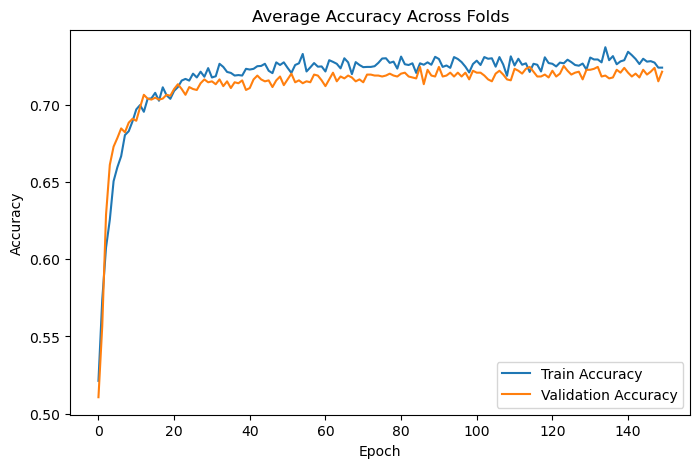

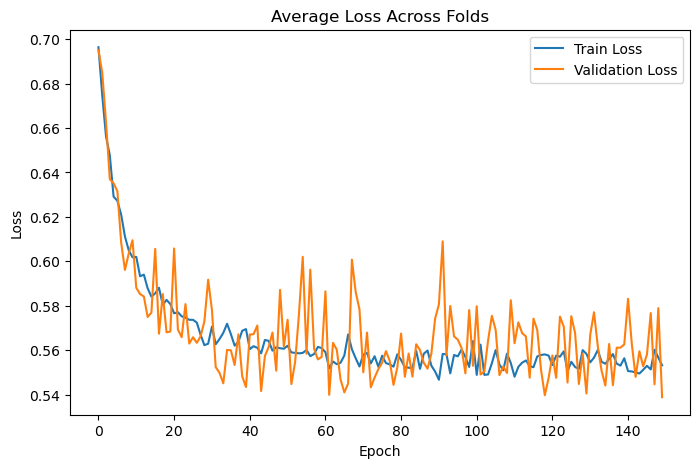

In [42]:
modelName = 'TorchX-SBU-RSNA_SGD_.00005_bs64'

histf = './history/'
histpath = os.path.join(histf, modelName)


all_histories = []
for fold_no in range(1, num_folds+1):
    with open(histpath + '/fold_' + str(fold_no) + '_history.pickle', 'rb') as file:
        history = pickle.load(file)
        all_histories.append(history)

# Find the minimum length of the history arrays
min_length = min(len(hist.history['train_accuracy']) for hist in all_histories)

# Truncate (or pad) all history arrays to this minimum length
train_accuracies = [hist.history['train_accuracy'][:min_length] for hist in all_histories]
val_accuracies = [hist.history['val_accuracy'][:min_length] for hist in all_histories]
train_losses = [hist.history['train_loss'][:min_length] for hist in all_histories]
val_losses = [hist.history['val_loss'][:min_length] for hist in all_histories]

# Calculate average accuracy and loss for training and validation
avg_train_accuracy = np.mean(train_accuracies, axis=0)
avg_val_accuracy = np.mean(val_accuracies, axis=0)
avg_train_loss = np.mean(train_losses, axis=0)
avg_val_loss = np.mean(val_losses, axis=0)

# Plot the average learning curve for accuracy
plt.figure(figsize=(8, 5))
plt.plot(avg_train_accuracy, label='Train Accuracy')
plt.plot(avg_val_accuracy, label='Validation Accuracy')
plt.title("Average Accuracy Across Folds")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.savefig(histpath+'/averaged_acc.png')
plt.show()

# Plot the average learning curve for loss
plt.figure(figsize=(8, 5))
plt.plot(avg_train_loss, label='Train Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.title("Average Loss Across Folds")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig(histpath+'/averaged_loss.png')
plt.show()